In [ ]:
'''
    -This proposed sky detecion CV algorithm is able to detect the contour of the sky pixels in the image and generate a mask image of the sky region.
    -The algorithm is able to perform subtasks: classifying the images into nighttime and daytime category and generate the mask images that show the skyline.
'''
import cv2
import os
import numpy as np
import shutil

# Define a function that determine the contour that contains the sky region
def determineContour(thres, nrow, ncol):

    # Find the contours of the threshold image by retrieving all the contours and compressing contour points and leaves only their end points
    contours, hierarchy = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if contours: # If there are contours
        # Create a blank image named mask to draw the contours
        mask = np.zeros((nrow, ncol), dtype=np.uint8)
        # Calculate the area of the mask
        area = nrow * ncol
        # Calculate the half area and half height of the mask
        halfArea = 0.5 * area
        halfHeight = 0.5 * nrow
        # Find the biggest contour
        maxC = max(contours, key=cv2.contourArea)

        # Iterate through the contours
        for c in contours:
            # Calculate the matched contour of the current contour and the biggest contour
            matchedCnt = cv2.matchShapes(c, maxC, 1, 0.0)
            # Get the bounding rectangle of the contour
            (x, y, w, h) = cv2.boundingRect(c)
            # Determine the bottom point of the contour
            bottomPoint = y + h
            # If the current contour's topmost point is at the top edge of the image
            if y == 0:
                # If the current contour is the biggest contour, meaning its a matched contour
                if matchedCnt == 0.0:
                    # If the current contour starts from the leftmost part
                    # and occupies a significant portion  of the image
                    if x == 0 and cv2.contourArea(c) >= halfArea:
                        cv2.drawContours(mask, [c], -1, (255), cv2.FILLED) # draw the contour on the mask

                    # If the current contour loacted at the upper part of the image
                    elif bottomPoint <= halfHeight:
                        cv2.drawContours(mask, [c], -1, (255), cv2.FILLED) # draw the contour on the mask

                # If the current contour is  larger than 1000 are considered more significant and are more likely to be part of the sky
                # and contour is located in the upper part of the image
                elif cv2.contourArea(c) > 1000 and bottomPoint <= halfHeight:
                    cv2.drawContours(mask, [c], -1, (255), cv2.FILLED) # draw the contour on the mask

    else: # If there are no contours
        mask = np.zeros((nrow, ncol), dtype=np.uint8)
    return mask

# Define a function that process the mask of sky region and determine if the image is a night or day image
def detectSkyRegion(dataset_number, file, previous_day_mask):
    isNightImage = False
    img = cv2.imread(f"{dataset_number}/{file}", 1)

    # Extract the blue channel from the coloured image and get its shape
    blueChnl = img[:,:,0]
    [nrow, ncol] = blueChnl.shape

    # Apply Gaussian blur to the filter image to reduce noise
    blueChnlGaussian = cv2.GaussianBlur(blueChnl, (3,3), 0)

    # Use Otsu’s method to determine the threshold during binarization
    val, thres = cv2.threshold(blueChnlGaussian, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Determine the contour of the threshold image
    mask = determineContour(thres, nrow, ncol)

    # Calculate the total number of non-zero/white pixels (which represent sky) in the mask
    total = np.sum(mask)

    # If the total number of non-zero pixels is 0, meaning the image is a nighttime image
    if total == 0:  # Nighttime image
        isNightImage = True # Set the flag to True
        if previous_day_mask is not None:
            mask = previous_day_mask  # Replace night mask with the previous day mask

    else:  # Daytime image
        isNightImage = False # Set the flag to False
        previous_day_mask = mask
    return mask, isNightImage, previous_day_mask

# Define a function that export the mask image into a new or created mask folder
def exportMask(mask_img, file, number):
    countNthEmptyMask = 0
    current_directory = os.getcwd()
    new_directory = os.path.join(current_directory, f"{number}_mask")
    # Create a new directory if it does not exist
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    filename = os.path.splitext(file)[0]
    # If the mask image is successfully generated and is not all black, export the mask image
    if mask_img is not None and not np.all(mask_img == 0):
        cv2.imwrite(os.path.join(new_directory, f"{filename}_mask.jpg"), mask_img)
    else: # if first nth night mask has no previous day mask
        countNthEmptyMask +=1 #increase count of empty mask without previous day mask
        # export the mask image
        cv2.imwrite(os.path.join(new_directory, f"{filename}_mask.jpg"), mask_img)
    return countNthEmptyMask

# Define a function that replace the several empty night mask which has no previous day mask with the first day mask
def replaceImageInFolder(mask_folder_path, nightfiles, firstDayMask,count_NthEmptyMask):
    # Get the first day mask
    firstDayMask = firstDayMask.replace(".jpg", "_mask.jpg")
    mask_files = os.listdir(mask_folder_path)
    # Loop through the nightfiles array
    for i in range(len(nightfiles)):
        # Replace the first nth empty night mask which has no previous day mask with the first day mask
        if i < count_NthEmptyMask:
            # Get the night mask from the nightfiles array
            nightMask = nightfiles[i].replace(".jpg", "_mask.jpg")
            #if the night mask image is found in the mask folder at index i, replace it with the first day mask
            if nightMask == mask_files[i]:
                source = os.path.join(mask_folder_path, mask_files[i])
                destination = os.path.join(mask_folder_path, firstDayMask)
                shutil.copyfile(destination, source)
                print(f"First night mask for dataset {number} has no previous day mask")
    return None

# Determine the accuracy of the algorithm by calculating the Intersection over Union (IoU) of the ground truth image and the generated mask image
def calculate_mIOU(gt_img, mask_path):
    total_iou = 0
    gt_area = np.count_nonzero(gt_img)
    mask_img_total = len(os.listdir(mask_path))

    for file in os.listdir(mask_path):
        mask_img_path = os.path.join(mask_path, file)
        mask_img = cv2.imread(mask_img_path, 1)
        mask_area = np.count_nonzero(mask_img)
        # Calculate the intersection of the ground truth image and the generated mask image
        intersection = np.count_nonzero(cv2.bitwise_and(gt_img, mask_img))
        # Calculate the union of the ground truth area and the generated mask area
        union = gt_area + mask_area - intersection
        # Calculate the Intersection over Union (IoU) by dividing the intersection by the union
        iou = intersection / union
        # Add the IoU to the total IoU for cumulative calculation
        total_iou += iou

    # Calculate the accuracy by dividing the total IoU by the total number of mask images
    mIOU = total_iou / mask_img_total
    return mIOU

# Determine the accuracy of the algorithm by calculating the accuracy of the ground truth image and the generated mask image
def calculate_accuracy(gt_img, mask_path):
    # Dertermine the total number of mask images
    mask_img_total = len(os.listdir(mask_path))

    # Convert the ground truth image to grayscale
    gt_gray = cv2.cvtColor(gt_img, cv2.COLOR_BGR2GRAY)
    _, mask_gt_bin = cv2.threshold(gt_gray, 1, 255, cv2.THRESH_BINARY)
    # Obtain inverted grouth truth image
    inverted_gt = np.ones(mask_gt_bin.shape, dtype=np.uint8) - mask_gt_bin
    # Obtain the total number of pixels of ground truth
    gt_total_pixels = mask_gt_bin.shape[0] * mask_gt_bin.shape[1]

    # Initialize the total number of true positives, false positives, true negatives and false negatives
    accuracy_total=0

    for file in os.listdir(mask_path):
        mask_img_path = os.path.join(mask_path, file)
        mask_img = cv2.imread(mask_img_path, 1)
        # Convert the mask image to grayscale and obtain its binary image
        mask_img_gray = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
        _, mask_img_bin = cv2.threshold(mask_img_gray, 1, 255, cv2.THRESH_BINARY)
        # Obtain inverted mask image
        inverted_mask = np.logical_not(mask_img_bin)

        # True Positives (TP)
        true_positive_mask = np.logical_and(mask_gt_bin, mask_img_bin)
        true_positives = np.count_nonzero(true_positive_mask)

        # False positives (FP)
        false_positive_mask = np.logical_and(inverted_gt, mask_img_bin)
        false_positives = np.count_nonzero(false_positive_mask)

        # True Negatives (TN)
        true_negative_mask = np.logical_and(inverted_gt, inverted_mask)
        true_negatives = np.count_nonzero(true_negative_mask)

        # False Negatives (FN)
        false_negative_mask = np.logical_and(mask_gt_bin, inverted_mask)
        false_negatives = np.count_nonzero(false_negative_mask)

        # Calculate accuracy by ratio of true positive pixels and true negative pixels to the total number of pixels in the ground truth image
        accuracy = (true_positives + true_negatives) / (gt_total_pixels)
        accuracy_total += accuracy

    avg_accuracy = accuracy_total / mask_img_total

    return avg_accuracy

# Define a function that detect the skyline from the mask image
def detectSkyline(maskImg):
    # Apply Canny edge detection
    edges = cv2.Canny(maskImg, threshold1=100, threshold2=200)  # Adjust the thresholds as needed

    # Perform post-processing to refine the edges
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)  # Closing operation to remove small gaps in edges

    # Find contours of the detected edges
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image to draw the shape line
    skylineImg = np.zeros_like(maskImg, dtype=np.uint8)

    # Iterate through the contours and draw them on the line image
    cv2.drawContours(skylineImg, contours, -1, (255, 255, 255), thickness=2)
    return skylineImg

# Define a function that export the skyline image into a new or created skyline folder
def exportSkylineImg(skylineImg, file, number):
    current_directory = os.getcwd()
    new_directory = os.path.join(current_directory, f"{number}_skyline")
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    filename = os.path.splitext(file)[0]
    cv2.imwrite(os.path.join(new_directory, f"{filename}_skyline.jpg"), skylineImg)
    return None

# Define the main function to run the algorithm
if __name__ == '__main__':
    # Store all the masks of night and day images
    nightFiles_total = []
    dayFiles_total = []
    nightFiles = []
    dayFiles =[]

    current_directory = os.getcwd() # Get the current directory
    dataset_number = ["1"] # List of dataset numbers

    #gt_path = os.path.join(current_directory, 'groundtruth') # Path to the ground truth directory

    for number in dataset_number:
        count_NthEmptyMask = 0
        previous_day_mask = None  # Initialize previous day mask
        nightFiles.clear() # Clear the list of night files
        dayFiles.clear() # Clear the list of day files

        dataset_directory = os.path.join(current_directory, number)  # Path to the dataset directory

        # Iterate over each file in the dataset directory
        print(os.listdir(dataset_directory))
        for file in os.listdir(dataset_directory):
            print(number,file)
            # Call the detectSkyRegion function to determine if the image is a night or day image and obtain its mask
            mask, isNightImage, previous_day_mask = detectSkyRegion(number, file, previous_day_mask)

            # If it is a mask of night image, append the night image to the nightFiles list
            if isNightImage:
                nightFiles.append(file)
                nightFiles_total.append(file)
             # If it is a mask of day image, append the day image to the dayFiles list
            else:
                dayFiles.append(file)
                dayFiles_total.append(file)

            # Export the mask
            countNthEmptyMask = exportMask(mask, file, number)
            # Update the count of empty masks of which do not have previous day mask
            count_NthEmptyMask += countNthEmptyMask

        # Replace the nth images (gathered from the count_NthEmptyMask) in the mask folder with the first day mask
        replaceImageInFolder(os.path.join(current_directory, f"{number}_mask"), nightFiles, dayFiles[0],count_NthEmptyMask)

    print(f'\n================================== Categorizing Nighttime and Daytime Images ==================================')
    print(f'Nighttime Images are: {nightFiles_total}')
    print('')
    print(f'Daytime Images are: {dayFiles_total}')
    print(f'================================================================================================================')

    '''print(f'\n================================== Evalutating performance for dataset  =======================================')
    for number1 in dataset_number:
        # Get the ground truth image and calculate the non-zero area of the froundtruth region
        gt_img_path = os.path.join(gt_path, f"{number1}.png")
        gt_img = cv2.imread(gt_img_path, 1)
        gt_area = np.count_nonzero(gt_img)

        # Get the total number of mask images from the mask folder
        mask_path = os.path.join(current_directory, f"{number1}_mask")
        mask_img_total = len(os.listdir(mask_path))
        print(f"Total number of mask images for dataset {number1}: {mask_img_total}")

        # Detect skyline from mask image and export skyline image
        for file in os.listdir(mask_path):
            maskImg_path = os.path.join(mask_path, file)
            maskImg = cv2.imread(maskImg_path,0)
            skyline_img = detectSkyline(maskImg)
            exportSkylineImg(skyline_img, file, number1)

        avg_accuracy = calculate_accuracy(gt_img, mask_path)
        print(f"Average accuracy for dataset {number1}: {avg_accuracy * 100:.2f}%")

        # Evaluate the performance of the obtained masks
        if gt_area  != 0: # Meaning ground truth image has sky region
            # Calculate mIOU
            mIOU = calculate_mIOU(gt_img, mask_path)
            print(f"Mean Intersection Over Union (mIOU) for dataset {number1}: {mIOU * 100:.2f}%\n")

    print(f'================================================================================================================')        '''

['sample.png']
1 sample.png

================================== Categorizing Nighttime and Daytime Images ==================================
Nighttime Images are: []

Daytime Images are: ['sample.png']


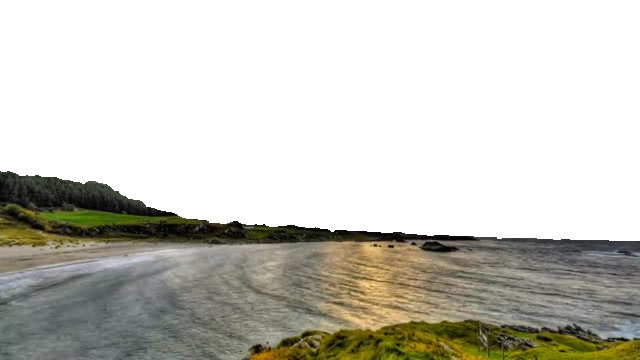

True

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
import numpy as np

# Read the original image
original_image = cv2.imread("1/sample.png")

# Read the mask image
mask = cv2.imread('1_mask/sample_mask.jpg', cv2.IMREAD_GRAYSCALE)

mask = cv2.GaussianBlur(mask, (11, 11), 0)
# Invert the mask
mask_inverse = cv2.bitwise_not(mask)

# Mask out the black part of the original image
cropped_image = cv2.bitwise_and(original_image, original_image, mask=mask_inverse)

white_canvas = np.full_like(original_image, 255)

# Copy the cropped part onto the white canvas
white_canvas[mask_inverse == 255] = cropped_image[mask_inverse == 255]

# Display the result
cv2_imshow(white_canvas)
cv2.imwrite('result_image.jpg', white_canvas)

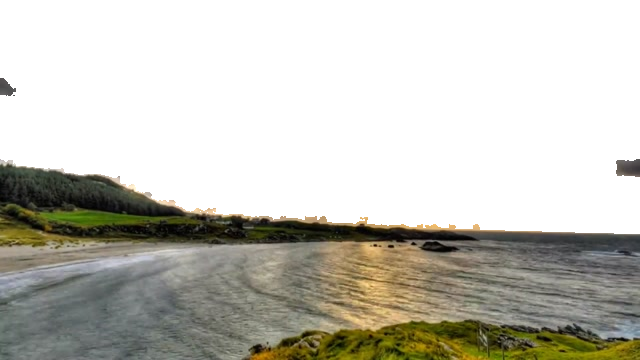

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the original image and the mask
original_image = cv2.imread('1/sample.png')
mask = cv2.imread('1_mask/sample_mask.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.GaussianBlur(mask, (5, 5), 0)

# Invert the mask
mask_inv = cv2.bitwise_not(mask)

# Delete the masked part of the original image
deleted_part = cv2.bitwise_and(original_image, original_image, mask=mask_inv)

# Make the deleted part transparent
deleted_part_with_alpha = cv2.cvtColor(deleted_part, cv2.COLOR_BGR2BGRA)
deleted_part_with_alpha[mask_inv == 0, 3] = 0  # Set alpha channel to 0 for the deleted part

# Save or display the resulting image
cv2.imwrite('Deleted Part with Transparency.png',deleted_part_with_alpha)
# Or display it using:
cv2_imshow(deleted_part_with_alpha)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Read the video
video_capture = cv2.VideoCapture('Supervised_Learning_Result.mp4')
mask = cv2.imread('1_mask/sample_mask.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.GaussianBlur(mask, (11, 11), 0)

# Read the image with transparent part
image = cv2.imread('Deleted Part with Transparency.png', cv2.IMREAD_UNCHANGED)

# Extract the alpha channel from the image
#alpha_channel = image[:, :, 3] / 255.0

width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (width, height), isColor=True)

# Iterate over frames in the video
while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    deleted_part = cv2.bitwise_and(frame, frame, mask=mask)

    deleted_part_with_alpha = cv2.cvtColor(deleted_part, cv2.COLOR_BGR2BGRA)
    deleted_part_with_alpha[mask == 0, 3] = 0  # Set alpha channel to 0 for the deleted part
    frame = deleted_part_with_alpha + image

    cv2_imshow(frame)
    print(np.shape(frame))
    output_video.write(frame)

# Release the video capture and close all windows
video_capture.release()
output_video.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read the video
video_capture = cv2.VideoCapture('output_video.mp4')

# Read frames from the video
while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    # Display the frame
    cv2_imshow(frame)

# Release the video capture and close all windows
video_capture.release()
cv2.destroyAllWindows()


In [ ]:
from moviepy.editor import VideoFileClip, ImageClip, CompositeVideoClip

# Load the video
video_clip = VideoFileClip('mask_cloud_4.avi')

# Load the image
image_clip = ImageClip('mask4.png')
image_clip = image_clip.set_duration(video_clip.duration)

# Resize the image to match the dimensions of the video
#image_clip = image_clip.resize(width=video_clip.w, height=video_clip.h)

# Place the image on top of the video
composite_clip = CompositeVideoClip([video_clip, image_clip.set_position('center')])

# Write the composite clip to a new video file
composite_clip.write_videofile('animating_output_video_40.mp4', codec='libx264', fps=video_clip.fps)

# Close the clips
video_clip.close()
composite_clip.close()

In [ ]:
from PIL import Image

def crop_to_square(image_path, output_path):
    # Open the image
    img = Image.open(image_path)

    # Get the dimensions of the image
    width, height = img.size

    # Determine the side length of the square
    side_length = min(width, height)

    # Calculate the coordinates for cropping the image to create a square
    left = (width - side_length) // 2
    top = (height - side_length) // 2
    right = left + side_length
    bottom = top + side_length

    # Crop the image to create a square
    cropped_img = img.crop((left, top, right, bottom))

    # Save the cropped image
    cropped_img.save(output_path)

# Example usage:
input_image_path = 'mask5.png'
output_image_path = 'crop_image_5.png'
crop_to_square(input_image_path, output_image_path)
